In [1]:
# Standard library imports
import os
import multiprocessing

# Third-party library imports
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# A. Dataset Preparation


### 1. Load Data

In this step, we will prepare the dataset that will be used for analysis. This process involves several important steps:

1. **Loading Shapefile**: We use the `load_shapefile_with_fiona` function. There are 4 shapefiles that will be loaded:

   - `gdf_training`: Training dataset that already have UHI Index value and some raster value
   - `gdf_additional`: Additional dataset from interpolation of gdf_training data that already have UHI Index value and some raster value
   - `gdf_testing`: Submission template that will be used for inference and already have some raster value
   - `gdf_evaluation`: Highest score from previous submission and already have UHI Index value with some raster value

2. **Converting Coordinates**: After loading the data, we convert the coordinate system of the additional dataset (`gdf_additional`) to EPSG:4326, which is a commonly used geographic coordinate system.

3. **Adding Longitude and Latitude Columns**: From the centroid geometry of each feature in `gdf_additional`, we extract the longitude and latitude values, which will be used for mapping the other raster value to data.

4. **Dropping Geometry Column**: After extracting the necessary information, we remove the geometry column from all DataFrames (`df_training`, `df_additional`, `df_testing`, and `df_evaluation`) to simplify the dataset and focus on the relevant attributes.


In [3]:
# PREPARING DATASET

# Function to load shp using Fiona lib
def load_shapefile_with_fiona(filepath, encoding='latin1'):
    # Open the shapefile with Fiona to capture all attributes
    with fiona.open(filepath, encoding=encoding) as src:
        features = list(src)
        gdf = gpd.GeoDataFrame.from_features(features, crs=src.crs)
    return gdf

# Loading the data using Fiona
gdf_training = load_shapefile_with_fiona('https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/modelling_data/Vector_AR_Dataset_Training_49ft.shp')
gdf_additional = load_shapefile_with_fiona('https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/modelling_data/Vector_AR_Dataset_TrainingAdditional_49ft.shp')
gdf_testing = load_shapefile_with_fiona('https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/modelling_data/Vector_AR_Dataset_Testing_49ft.shp')
gdf_evaluation = load_shapefile_with_fiona('https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/modelling_data/Vector_AR_ReferencedSHP_49ft.shp')


gdf_additional = gdf_additional.to_crs("EPSG:4326")

# Buat kolom Longitude dan Latitude dari centroid geometry
gdf_additional["Longitude"] = gdf_additional["geometry"].centroid.x
gdf_additional["Latitude"] = gdf_additional["geometry"].centroid.y

# Drop the geometry column
df_training = gdf_training.drop(columns='geometry')
df_additional = gdf_additional.drop(columns='geometry')
df_testing = gdf_testing.drop(columns='geometry')
df_evaluation = gdf_evaluation.drop(columns='geometry')

C:\Users\faisa\AppData\Local\Temp\ipykernel_8064\1250229998.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_additional["Longitude"] = gdf_additional["geometry"].centroid.x
C:\Users\faisa\AppData\Local\Temp\ipykernel_8064\1250229998.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_additional["Latitude"] = gdf_additional["geometry"].centroid.y


### 2. Mapping Additional Raster Value to Data


The dataset already have raster value but we will add more raster value to the dataset to improve the model performance. Some of the raster data are sentinel3, sentinel1, sentinel2, topography, landsat, and some special indices.


In [4]:
# Parameter
LANDSAT_DIR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/landsat.tif"
S1_DIR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/s1_image.tif"
BUILDING_DIR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/building.tif"
SAMPLE_DIR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/sample.geojson"
TOPO_DIR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/topography.tif"
S3_SLSTR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/s3_slstr.tif"
S3_LAND = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/s3_land.tif"
S3_WATER = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/s3_water.tif"
S3_AEROSOL = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/s3_aerosol.tif"
S3_SR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/s3_sr.tif"
TEST_DIR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/data/Submission_template_UHI2025-v2.csv"
S1_DOWNSCALE_DIR = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/s1_downscale.tif"
SPECIAL_INDICES = "https://storage.googleapis.com/gee-ramiqcom-s4g-bucket/ey_uhi/special_indices.tif"

In [5]:
# # Parameter
# LANDSAT_DIR = "./dataset/raster/landsat.tif"
# S1_DIR = "./dataset/raster/s1_image.tif"
# BUILDING_DIR = "./dataset/raster/building.tif"
# TOPO_DIR = "./dataset/raster/topography.tif"
# S3_SLSTR = "./dataset/raster/s3_slstr.tif"
# S3_LAND = "./dataset/raster/s3_land.tif"
# S3_WATER = "./dataset/raster/s3_water.tif"
# S3_AEROSOL = "./dataset/raster/s3_aerosol.tif"
# S3_SR = "./dataset/raster/s3_sr.tif"
# TEST_DIR = "./dataset/Submission_template_UHI2025-v2.csv"
# S1_DOWNSCALE_DIR = "./dataset/raster/s1_downscale.tif"
# SPECIAL_INDICES = "./dataset/raster/special_indices.tif"

This section of the code is extracting raster data from various additional sources and mapping it to the datasets. The following steps are performed:

1. **Define Indices and Bands**: Various indices (e.g., NDMI, NBR) and bands for different satellite data (Sentinel-1, Sentinel-2, Landsat) are defined.

2. **Extract Raster Data**: A function `extract_raster_data` is created to sample raster values based on the coordinates (Longitude and Latitude) from the datasets.

3. **Process Each Dataset**: For each dataset (training, additional, testing, evaluation):
   - Raster data is extracted from Landsat, Sentinel-1, and other sources.
   - New indices are calculated based on the extracted bands.
   - The geometry column is dropped if present, and rows with NoData values are filtered out.


In [7]:
# Sample sentinel-2, sentinel-1, special indices
label = "UHI Index"

# Load images and its indices
ms_indices = [
    dict(name="NDMI", band1="NIR", band2="SWIR1", cmap="RdYlGn"),
    dict(name="NBR", band1="NIR", band2="SWIR2", cmap="RdYlGn"),
    dict(name="NBR2", band1="SWIR1", band2="SWIR2", cmap="RdYlGn"),
    dict(name="NDWI", band1="GREEN", band2="NIR", cmap="RdBu"),
    dict(name="MNDWI", band1="GREEN", band2="SWIR1", cmap="RdBu"),
    dict(name="MNDWI2", band1="GREEN", band2="SWIR2", cmap="RdBu"),
    dict(name="NDVI", band1="NIR", band2="RED", cmap="RdYlGn"),
    dict(name="NDTI", band1="GREEN", band2="RED", cmap="RdYlGn"),
]
landsat_band_map = dict(BLUE=1, GREEN=2, RED=3, NIR=4, SWIR1=5, SWIR2=6)
s1_indices = [
    dict(name="RVI", band1="VV", band2="VH", cmap="RdYlGn"),
]
s1_band_map = dict(VV=0, VH=1)

bands_s1 = ["VV", "VH"]
bands_topo = ["elevation", "slope", "aspect"]
bands_landsat = ["COASTAL", "BLUE", "GREEN", "RED", "NIR", "SWIR1", "SWIR2", "LST"]
bands_s3_lst = ["S3_SLSTR"]
bands_special = ["Dryness", "Greeness", "Wetness", "Hotness", "TPI"]
# bands_special = ["Dryness", "Greeness", "Wetness", "Hotness", "TPI", "Mean_Landsat", "Std_Landsat", "CV_Landsat"]
s3_land_bands = ["IWV", "OGVI", "OTCI", "RC681", "RC865"]
s3_water_bands = ["IWV_Water", "PAR", "KD490_M07", "A865", "T865", "CHL_NN"]


datasets = [df_training, df_additional, df_testing, df_evaluation]

# Fungsi untuk ekstraksi data dari raster
def extract_raster_data(source, df, bands):
    coords = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
    df[bands] = list(source.sample(coords))

# Proses ekstraksi untuk setiap dataset
for df in datasets:
    with rio.open(LANDSAT_DIR) as source:
        extract_raster_data(source, df, bands_landsat)

        # Also indices
        for props in ms_indices:
            name = props["name"]
            band1 = props["band1"]
            band2 = props["band2"]

            df[name] = (df[band1] - df[band2]) / (df[band1] + df[band2])

    with rio.open(S1_DOWNSCALE_DIR) as source:
        extract_raster_data(source, df, bands_s1)

        for props in s1_indices:
            name = props["name"]
            band1 = props["band1"]
            band2 = props["band2"]

            df[name] = (df[band1] - df[band2]) / (df[band1] + df[band2])

    with rio.open(SPECIAL_INDICES) as source:
        extract_raster_data(source, df, bands_special)

    with rio.open(TOPO_DIR) as source:
        extract_raster_data(source, df, bands_topo)

    with rio.open(S3_SLSTR) as source:
        extract_raster_data(source, df, bands_s3_lst)

    with rio.open(S3_LAND) as source:
        extract_raster_data(source, df, s3_land_bands)

    with rio.open(S3_WATER) as source:
        extract_raster_data(source, df, s3_water_bands)

    # Filter NoData
    df = df[df["BLUE"] >= 0]

    # Drop geometry column if there is any
    df = df[df.columns[3:]]
    if "geometry" in df.columns:
        del df["geometry"]

df

,Xb1_mean,Xb2_mean,Xb3_mean,Xb4_mean,Xb5_mean,Xb6_mean,Xb7_mean,Xb8_mean,Xb9_mean,Xb10_mean,...,OGVI,OTCI,RC681,RC865,IWV_Water,PAR,KD490_M07,A865,T865,CHL_NN
0,0.052291,0.066772,0.060363,0.267444,0.634582,-0.602456,226.997980,35.156560,63.320195,31.556874,...,0.206693,3.224410,0.055033,0.173490,38.999996,1775.000000,-0.464567,0.074803,0.481890,0.952756
1,0.069403,0.087852,0.081224,0.281486,0.547786,-0.519429,260.481485,70.573984,51.168022,115.271912,...,0.206693,3.224410,0.055033,0.173490,38.999996,1775.000000,-0.464567,0.074803,0.481890,0.952756
2,0.084083,0.098789,0.114202,0.156616,0.163149,-0.229525,524.353104,152.774529,84.751030,72.094835,...,0.145669,2.725394,0.114475,0.219550,31.953962,1822.047852,-0.586476,0.220362,0.135085,0.185991
3,0.123324,0.148290,0.167695,0.202134,0.097928,-0.162221,220.800617,156.584708,66.533955,144.075498,...,0.206693,3.224410,0.055033,0.173490,38.999996,1775.000000,-0.464567,0.074803,0.481890,0.952756
4,0.059500,0.075328,0.069316,0.321337,0.651688,-0.627572,210.640459,167.332743,48.408034,65.045651,...,0.145669,2.725394,0.114475,0.219550,31.953962,1822.047852,-0.586476,0.220362,0.135085,0.185991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,0.109915,0.127337,0.132792,0.151934,0.069993,-0.088847,22.042686,257.177128,24.509521,462.396467,...,0.137795,2.303150,0.121471,0.223189,33.533562,1808.747925,-0.468841,0.425564,0.130263,0.373451
1036,0.127627,0.149391,0.147095,0.348909,0.446153,-0.427962,104.019391,146.952503,71.070399,15.032818,...,0.210630,3.377953,0.086589,0.219565,34.708893,1807.168335,-0.182036,0.507714,0.122975,0.354610
1037,0.116070,0.139620,0.141530,0.273230,0.314122,-0.317683,122.979849,80.049850,7.116341,44.197491,...,0.338583,4.734252,0.025536,0.188742,43.499996,1778.346436,0.226378,0.769291,0.201575,0.740157
1038,0.204488,0.219864,0.243655,0.305173,0.131749,-0.178216,76.435643,150.406065,61.742744,166.291903,...,0.137795,2.303150,0.121471,0.223189,33.533562,1808.747925,-0.468841,0.425564,0.130263,0.373451


### 3. Data Cleaning


In this section, we perform data cleaning on the datasets. The following steps are taken:

1. **Eliminate Unused Columns**: We remove columns that are not needed for the analysis, specifically the "Longitude", "Latitude", and "datetime" columns from all datasets (`df_training`, `df_additional`, `df_testing`, and `df_evaluation`). This helps to simplify the datasets and focus on the relevant features.

2. **Renaming Columns**: The columns of the datasets are renamed to a new set of descriptive names. This makes it easier to understand the data and ensures consistency across the datasets.

3. **Convert Columns to Numeric**: The first 26 columns of the new column names are converted to numeric types, coercing any errors to NaN. This is important for ensuring that the data can be used in mathematical operations and modeling.

4. **Combine Datasets**: The training and additional datasets are combined into a single DataFrame (`df_combined`) using row binding. This allows for a more comprehensive analysis and modeling.

5. **Eliminate Rows with Null Values**: Any rows with null values in the combined dataset are removed to ensure that the analysis is performed on complete data.


In [9]:
# Eliminate unused columns
cols_to_remove = ["Longitude", "Latitude", "datetime"]
df_training = df_training.drop(columns=cols_to_remove, errors='ignore')
df_additional = df_additional.drop(columns=cols_to_remove, errors='ignore')
df_testing = df_testing.drop(columns=cols_to_remove, errors='ignore')
df_evaluation = df_evaluation.drop(columns=cols_to_remove, errors='ignore')

# Renaming columns
new_columns = ['Y_IndexUHI', 'X_Mult_Blue', 'X_Mult_Green', 'X_Mult_Red', 'X_Mult_Nir', 'X_Mult_NDVI', 'X_Mult_NDWI',
               'X_DEM_Elevation', 'X_DEM_Aspect', 'X_DEM_Slope', 'X_DEM_Radiation', 'X_Thermal_L8B10', 'X_Thermal_TSharp_Rlm',
               'X_Thermal_TSharp_Svm', 'X_Thermal_NonTSharp_Rlm', 'X_Thermal_NonTSharp_Svm', 'X_Bool_Park', 'X_Proxy_Park',
               'X_Proxy_Water', 'X_Proxy_Tree', 'X_Proxy_Road', 'X_Proxy_Rail', 'X_Proxy_Impe', 'X_Proxy_GrasShrub',
               'X_Proxy_Building', 'X_Proxy_Soil', 'COASTAL', 'BLUE', 'GREEN',
               'RED', 'NIR', 'SWIR1', 'SWIR2', 'LST', 'NDMI', 'NBR', 'NBR2', 'NDWI',
               'MNDWI', 'MNDWI2', 'NDVI', 'NDTI', 'VV', 'VH', 'RVI', 'Dryness',
               'Greeness', 'Wetness', 'Hotness', 'TPI', 'elevation', 'slope', 'aspect',
               'S3_SLSTR', 'IWV', 'OGVI', 'OTCI', 'RC681', 'RC865', 'IWV_Water', 'PAR',
               'KD490_M07', 'A865', 'T865', 'CHL_NN']

df_training.columns = new_columns
df_additional.columns = new_columns
df_testing.columns = new_columns
df_evaluation.columns = new_columns

# Convert the first 26 columns to numeric (coercing errors to NaN)
for col in new_columns[:26]:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce')
    df_additional[col] = pd.to_numeric(df_additional[col], errors='coerce')
    df_testing[col] = pd.to_numeric(df_testing[col], errors='coerce')
    df_evaluation[col] = pd.to_numeric(df_evaluation[col], errors='coerce')

# Combine the training and additional datasets (row binding)
df_combined = pd.concat([df_training, df_additional], ignore_index=True)

# Eliminate rows with null values
df_combined = df_combined.dropna()

# View the resulting DataFrame
print(df_combined.head(5))

   Y_IndexUHI  X_Mult_Blue  X_Mult_Green  X_Mult_Red  X_Mult_Nir  X_Mult_NDVI  \
0    1.030289     0.075673      0.094030    0.092984    0.190277     0.330546   
1    1.030289     0.064656      0.081781    0.081981    0.189694     0.376541   
2    1.023798     0.056292      0.072539    0.075230    0.200915     0.436132   
3    1.023798     0.057165      0.072958    0.072897    0.201145     0.445764   
4    1.021634     0.069102      0.083798    0.083886    0.203587     0.401400   

   X_Mult_NDWI  X_DEM_Elevation  X_DEM_Aspect  X_DEM_Slope  ...      OGVI  \
0    -0.327461        91.041942     90.845314    57.979130  ...  0.159449   
1    -0.381389        96.891921    115.407736    52.992105  ...  0.159449   
2    -0.451616       103.989218    116.275768    60.442171  ...  0.159449   
3    -0.447661        87.805892    147.782933    54.623753  ...  0.159449   
4    -0.402436        78.818835    145.729656    51.143506  ...  0.159449   

       OTCI     RC681     RC865  IWV_Water        

In [10]:
df_training.to_csv("./dataset/csv_mapmatched/df_training.csv")
df_additional.to_csv("./dataset/csv_mapmatched/df_additional.csv")
df_testing.to_csv("./dataset/csv_mapmatched/df_testing.csv")
df_evaluation.to_csv("./dataset/csv_mapmatched/df_evaluation.csv")
df_combined.to_csv("./dataset/csv_mapmatched/df_combined.csv")

# B. Model Development


### 1. Explanatory Data Analysis


In this section, we compute the correlation matrix for the combined dataset to understand the relationships between different features.

1. **Compute Correlation Matrix**: The correlation matrix is calculated using the combined dataset (training and additional), which helps identify how features are related to each other.

2. **Visualize with Heatmap**: A heatmap is created using Matplotlib to visually represent the correlation values. The 'coolwarm' colormap is used for better clarity.

3. **Add Colorbar and Annotations**: A colorbar is added to indicate the scale of correlation values, and text annotations are included in each cell of the heatmap to display the exact correlation coefficients.

4. **Adjust Layout**: The layout is adjusted for better presentation, and a title is added to the heatmap.


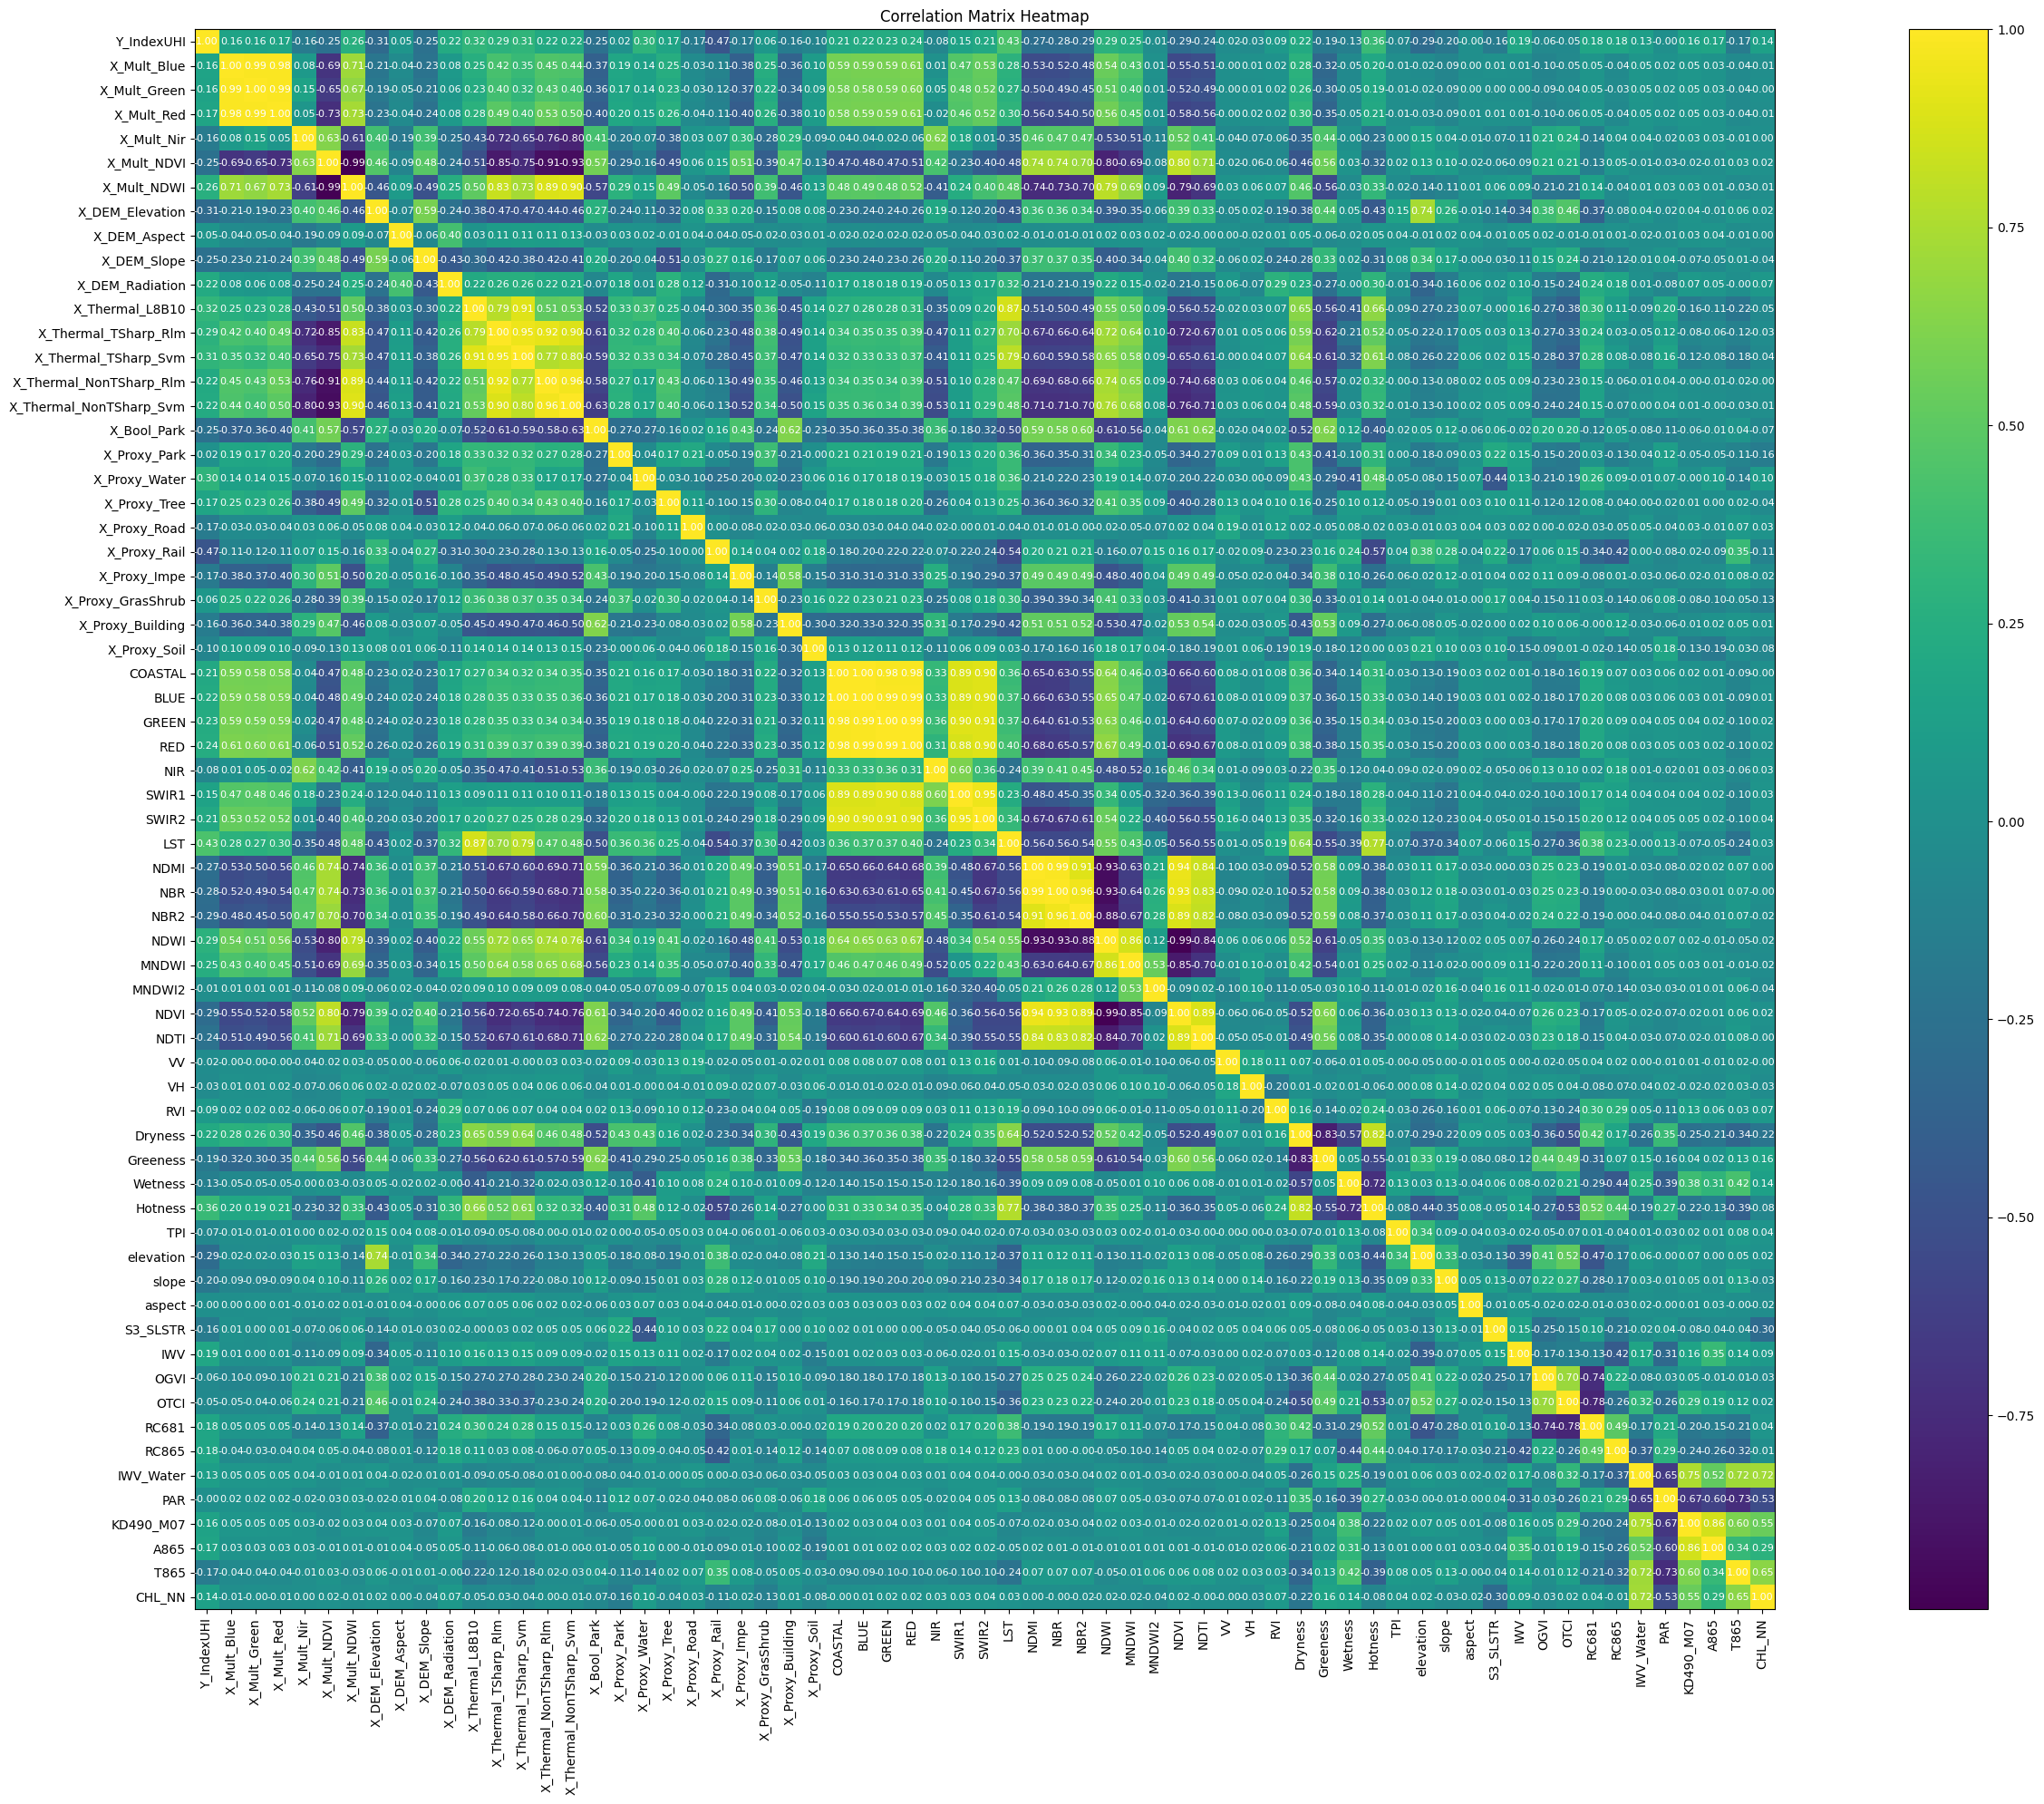

In [11]:
## EXPLANATORY DATA ANALYSIS

# Compute the correlation matrix for the combined dataset
corr_matrix = df_combined.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 20))

# Create a heatmap using imshow with a 'coolwarm' colormap
cax = ax.imshow(corr_matrix, interpolation='nearest')

# Add a colorbar to show the scale
fig.colorbar(cax)

# Set tick positions and labels with variable names
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

# Add text annotations in each cell with the correlation value
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="white", fontsize=8)

# Add a title and adjust layout
ax.set_title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

### 2. Hyperparameter Tuning


This section focuses on optimizing the hyperparameters of the Random Forest model using Grid Search.

1. **Define Predictors and Response**: The predictors (features) and response (target variable which is UHI Index) are defined based on the previously established column names.

2. **Create Feature Matrices and Target Vectors**: Feature matrices and target vectors are created for both training and evaluation datasets.

3. **Combine Datasets**: The training and evaluation datasets are combined to facilitate hyperparameter tuning.

4. **Predefined Split**: A `PredefinedSplit` is created to differentiate between training and evaluation samples, ensuring that the grid search trains on the combined dataset and validates on the evaluation dataset.

5. **Parameter Grid Definition**: A parameter grid is defined for the Random Forest model, specifying different values for `n_estimators` (number of trees) and `max_features` (number of features to consider).

6. **Grid Search Setup**: A `GridSearchCV` instance is created to perform cross-validation and find the best hyperparameters based on the R² scoring metric.

7. **Model Fitting**: The grid search is executed to fit the model and identify the best parameters.


In [12]:
# Define predictors and response using the new_columns from earlier steps.
# Response is the first column and predictors are the rest.
predictors = new_columns[1:]
response = new_columns[0]

# Create feature matrices and target vectors for training and evaluation data
X_train = df_combined[predictors]
y_train = df_combined[response]

X_eval = df_evaluation[predictors]
y_eval = df_evaluation[response]

# Combine training and evaluation data
X_all = pd.concat([X_train, X_eval], axis=0)
y_all = pd.concat([y_train, y_eval], axis=0)

# Create a PredefinedSplit: assign -1 to training samples and 0 to evaluation samples.
# This ensures that grid search always trains on df_combined and validates on df_testing.
test_fold = [-1] * len(X_train) + [0] * len(X_eval)
ps = PredefinedSplit(test_fold=test_fold)

# # Parameter grid for RandomForest:
# # 'n_estimators' corresponds to the number of trees and 'max_features' to mtry.
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_features': [10, 20, 30]
}


# Create the RandomForestRegressor model
model_reg = RandomForestRegressor(random_state=42)

# Set up GridSearchCV with our PredefinedSplit
grid_search = GridSearchCV(estimator=model_reg,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=ps,
                        #    n_jobs=n_jobs,
                           refit=False)
grid_search.fit(X_all, y_all)

# print details
print("Best parameters found:", grid_search.best_params_)
print("Best CV R^2 score:", grid_search.best_score_)

Best parameters found: {'max_features': 30, 'n_estimators': 1000}
Best CV R^2 score: 0.9942744834322281


### 3. Model Training and Evaluation for Baseline Model


In this section, we fit the Random Forest model using the training data.

1. **Best Parameters Retrieval**: The best hyperparameters obtained from the grid search are retrieved.

2. **Model Initialization**: A `RandomForestRegressor` model is initialized with the retrieved best parameters and a fixed random state for reproducibility.

3. **Model Training**: The model is trained on the training dataset (`X_train` and `y_train`).
4. **Model Evaluation**: The model's performance is evaluated on both the training and evaluation datasets:
   - Predictions are made on the training data, and the R² score is calculated to assess how well the model fits the training data.
   - Predictions are also made on the evaluation data, with the R² score calculated to evaluate the model's generalization performance.



In [13]:
## MODEL FITTING
# Fit the model on the training data only.
best_params = grid_search.best_params_
model_reg_best = RandomForestRegressor(random_state=42, **best_params)
model_reg_best.fit(X_train, y_train)

# Evaluate the model on the training and evaluation dataset
x_pred_train = model_reg_best.predict(X_train)
eval_r2 = r2_score(y_train, x_pred_train)
print("Evaluation R^2 on training data:", eval_r2)

y_pred_eval = model_reg_best.predict(X_eval)
eval_r2 = r2_score(y_eval, y_pred_eval)
print("Evaluation R^2 on evaluation data:", eval_r2)

Evaluation R^2 on training data: 0.9983730618218489
Evaluation R^2 on evaluation data: 0.9942744834322281


This code defines a function `plot_1to1` that creates a 1:1 scatter plot to compare observed and predicted values from a regression model. Then, it generates predictions for both the training and evaluation datasets using the best regression model (`model_reg_best`). It then creates side-by-side subplots to visualize the relationship between observed and predicted values for each dataset.

Key steps include:
- **Generating Predictions**: Predictions are made for both training (`y_train_pred`) and evaluation (`y_eval_pred`) datasets.
- **Creating Subplots**: A figure with two subplots is created to display the 1:1 scatter plots for training and evaluation data.
- **Plotting**: The `plot_1to1` function is called for both datasets, allowing for a visual comparison of observed vs. predicted values.
- **Displaying the Plot**: The layout is adjusted for better spacing, and the plots are displayed using `plt.show()`.

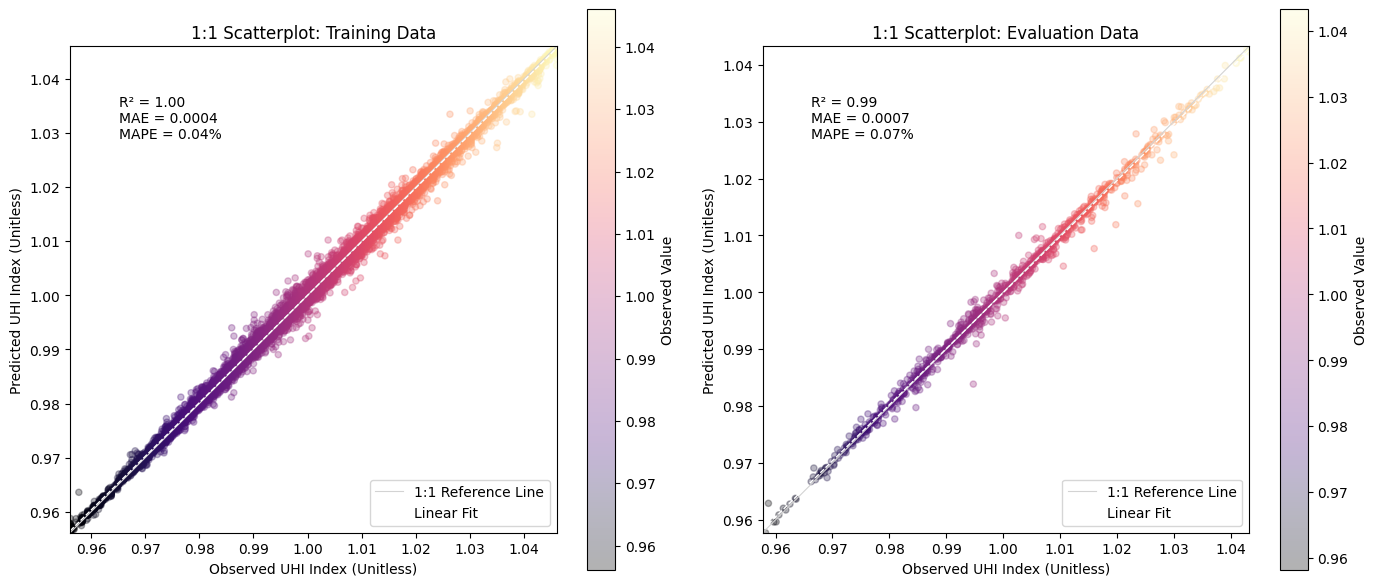

In [14]:
## MODEL EVALUATION
# Function to make 1:1 plot
def plot_1to1(observed, predicted, dataset_label="", ax=None):
    """
    Create a 1:1 scatterplot comparing observed and predicted values,
    compute evaluation metrics, and annotate the plot with R², MAE, and MAPE.

    Parameters:
      observed (array-like): Observed values.
      predicted (array-like): Predicted values.
      dataset_label (str): Label to include in the title (e.g., "Training Data" or "Evaluation Data").
      ax (matplotlib.axes.Axes): Optional axis to plot on.

    Returns:
      ax: The axis with the plot.
    """
    # Compute evaluation metrics
    r2 = r2_score(observed, predicted)
    mae = mean_absolute_error(observed, predicted)
    mape = np.mean(np.abs((observed - predicted) / observed)) * 100

    # Format metrics for annotation
    r2_label = f"R² = {r2:.2f}"
    mae_label = f"MAE = {mae:.4f}"
    mape_label = f"MAPE = {mape:.2f}%"

    # Determine common limits for both observed and predicted
    all_vals = np.concatenate([observed, predicted])
    x_lim_min = np.nanmin(all_vals)
    x_lim_max = np.nanmax(all_vals)

    # Set annotation coordinates as fractions of the range
    ann_x = x_lim_min + 0.1 * (x_lim_max - x_lim_min)
    ann_y = x_lim_max - 0.1 * (x_lim_max - x_lim_min)

    # If no axis provided, create one
    if ax is None:
        fig, ax = plt.subplots()

    # Create scatter plot: points colored by the observed value using the "magma" colormap
    sc = ax.scatter(observed, predicted, c=observed, cmap="magma", alpha=0.3, s=20)
    plt.colorbar(sc, ax=ax, label="Observed Value")

    # Plot 1:1 reference line
    ax.plot([x_lim_min, x_lim_max], [x_lim_min, x_lim_max], color="lightgray",
            linewidth=0.8, linestyle="solid", label="1:1 Reference Line")

    # Compute linear regression fit (predicted ~ observed) and plot the fitted line
    slope, intercept = np.polyfit(observed, predicted, 1)
    x_vals = np.array([x_lim_min, x_lim_max])
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color="white", linewidth=1, linestyle="dashed", label="Linear Fit")

    # Set labels and title
    ax.set_xlabel("Observed UHI Index (Unitless)")
    ax.set_ylabel("Predicted UHI Index (Unitless)")
    ax.set_title(f"1:1 Scatterplot: {dataset_label}")

    # Annotate with metrics
    ax.text(ann_x, ann_y, f"{r2_label}\n{mae_label}\n{mape_label}",
            color="black", fontsize=10, ha="left", va="top")

    # Set fixed aspect ratio and limits
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(x_lim_min, x_lim_max)
    ax.set_aspect('equal', adjustable='box')

    ax.legend(loc="lower right")

    return ax

# Generate predictions for both datasets
y_train_pred = model_reg_best.predict(X_train)
y_eval_pred = model_reg_best.predict(X_eval)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training data
plot_1to1(y_train.values, y_train_pred, dataset_label="Training Data", ax=ax1)

# Plot evaluation data
plot_1to1(y_eval.values, y_eval_pred, dataset_label="Evaluation Data", ax=ax2)

plt.tight_layout()
plt.show()

# C. Feature Selection


This code snippet performs feature selection using `RFECV` from scikit-learn. It aims to identify the optimal subset of features that maximizes the R^2 score of a trained regression model (`model_reg_best`).

1.  **Initialization:** An `RFECV` object is created, using `model_reg_best` as the estimator. The `step=1` parameter indicates that one feature will be eliminated at each iteration. Cross-validation is performed using the `ps` object, and the $R^2$ score is used for evaluation.
2.  **Fitting:** The `RFECV` object is fitted to the entire dataset (`X_all`, `y_all`).
3.  **Optimal Features Identification:** The optimal number of features and the corresponding feature names are extracted and printed.
4.  **Feature Ranking (Optional):** The ranking of all features is displayed, where lower ranks indicate higher importance.


In [15]:
## FEATURE SELECTION
# Import required libs
from sklearn.feature_selection import RFECV

# Use RFECV with the trained model (model_reg_best) as the estimator.
# RFECV will fit the model on the training data and evaluate on the eval data at each step.
rfecv = RFECV(estimator=model_reg_best, min_features_to_select=5, step=1, cv=ps, scoring='r2')
rfecv.fit(X_all, y_all)

# Output the optimal number of features and the selected feature names
optimal_features = [feature for feature, selected in zip(predictors, rfecv.support_) if selected]
print("Optimal number of features:", rfecv.n_features_)
print("Optimal number of features:", len(optimal_features))
print("Selected features:", optimal_features)

# # Optionally, view the ranking of all features (lower rank means more important)
ranking_dict = dict(zip(predictors, rfecv.ranking_))
print("Feature ranking:", ranking_dict)

Optimal number of features: 13
Optimal number of features: 13
Selected features: ['X_Proxy_Water', 'X_Proxy_Rail', 'X_Proxy_Soil', 'LST', 'Dryness', 'Greeness', 'Wetness', 'Hotness', 'elevation', 'S3_SLSTR', 'IWV', 'PAR', 'KD490_M07']
Feature ranking: {'X_Mult_Blue': 49, 'X_Mult_Green': 46, 'X_Mult_Red': 40, 'X_Mult_Nir': 29, 'X_Mult_NDVI': 9, 'X_Mult_NDWI': 35, 'X_DEM_Elevation': 5, 'X_DEM_Aspect': 50, 'X_DEM_Slope': 41, 'X_DEM_Radiation': 42, 'X_Thermal_L8B10': 2, 'X_Thermal_TSharp_Rlm': 43, 'X_Thermal_TSharp_Svm': 23, 'X_Thermal_NonTSharp_Rlm': 51, 'X_Thermal_NonTSharp_Svm': 45, 'X_Bool_Park': 52, 'X_Proxy_Park': 3, 'X_Proxy_Water': 1, 'X_Proxy_Tree': 25, 'X_Proxy_Road': 6, 'X_Proxy_Rail': 1, 'X_Proxy_Impe': 33, 'X_Proxy_GrasShrub': 11, 'X_Proxy_Building': 10, 'X_Proxy_Soil': 1, 'COASTAL': 37, 'BLUE': 44, 'GREEN': 47, 'RED': 48, 'NIR': 21, 'SWIR1': 31, 'SWIR2': 38, 'LST': 1, 'NDMI': 32, 'NBR': 39, 'NBR2': 26, 'NDWI': 16, 'MNDWI': 7, 'MNDWI2': 34, 'NDVI': 27, 'NDTI': 36, 'VV': 28, 'V

# D. Model training & evaluation (optimized model)


### 1. Model Training


This code segment refits a `RandomForestRegressor` using only the features selected by the `RFECV` process.

1.  **Subset data:** `X_train` and `X_eval` are filtered to include only the selected features.
2.  **Train new model:** A `RandomForestRegressor` (`model_reg_final`) is trained on the reduced `X_train`.
3.  **Evaluate:** $R^2$ scores are calculated for both training and evaluation sets using the new model.
4.  **Output:** Training and evaluation $R^2$ scores are printed.


In [16]:
## MODEL REFITTING
# Subset the training and evaluation data to only include the selected features
X_train_selected = X_train[optimal_features]
X_eval_selected = X_eval[optimal_features]

# Create and train a new RandomForestRegressor using only the selected features
model_reg_final = RandomForestRegressor(random_state=42, **best_params)
model_reg_final.fit(X_train_selected, y_train)

# Evaluate the new model on training data
train_predictions = model_reg_final.predict(X_train_selected)
train_r2 = r2_score(y_train, train_predictions)
print("Training R² with selected features:", train_r2)

# Evaluate the new model on evaluation data
eval_predictions = model_reg_final.predict(X_eval_selected)
eval_r2 = r2_score(y_eval, eval_predictions)
print("Evaluation R² with selected features:", eval_r2)

Training R² with selected features: 0.9984484477200488
Evaluation R² with selected features: 0.9949703383523779


### 2. Model Evaluation


This code re-evaluates the refitted model and visualizes its performance.

1.  **Predictions:** Generate predictions for the training and evaluation sets using the refitted model (`model_reg_final`) and the selected features.
2.  **Visualization:**
    * Create two subplots: one for training data and one for evaluation data.
    * Use the `plot_1to1` function to visualize the model's performance on each dataset.
    * Display the plots.

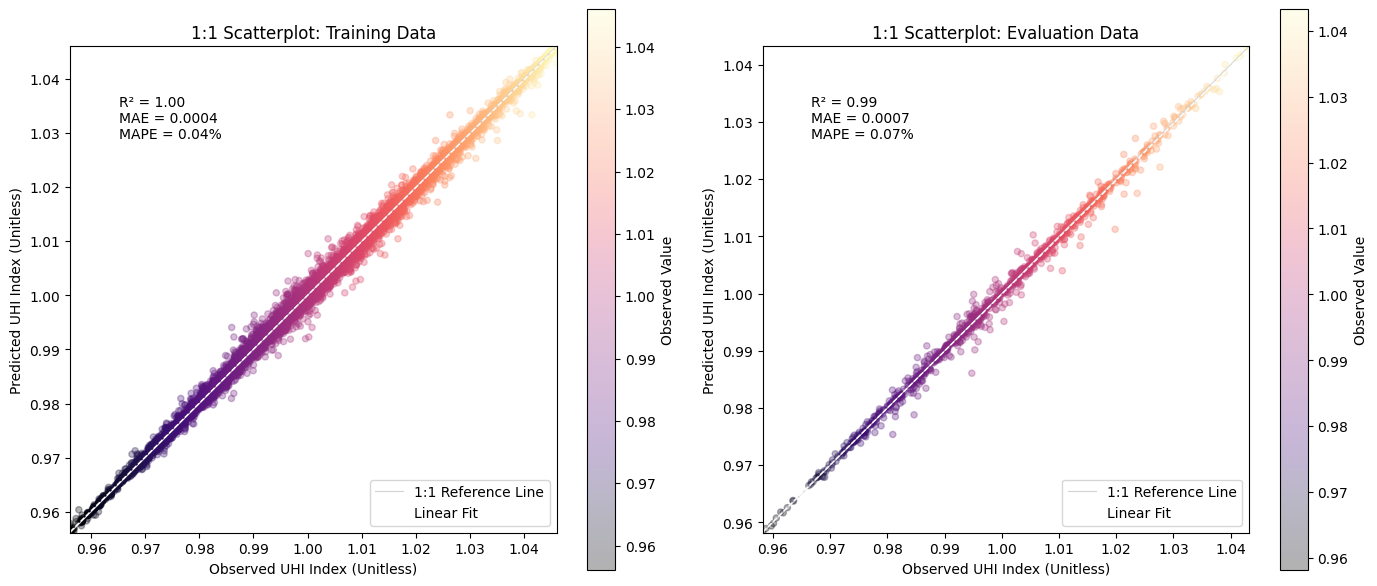

In [17]:
## MODEL REEVALUATION
# Generate predictions for both datasets
y_train_pred_selected = model_reg_final.predict(X_train[optimal_features])
y_eval_pred_selected = model_reg_final.predict(X_eval[optimal_features])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training data
plot_1to1(y_train.values, y_train_pred_selected, dataset_label="Training Data", ax=ax1)

# Plot evaluation data
plot_1to1(y_eval.values, y_eval_pred_selected, dataset_label="Evaluation Data", ax=ax2)

plt.tight_layout()
plt.show()

### 3. Model Tuning


This code retunes the `RandomForestRegressor` using the features selected by `RFECV`, aiming to find the optimal hyperparameters for the reduced feature space.

1.  **Combine Data:** Concatenate the selected training (`X_train_selected`, `y_train`) and evaluation (`X_eval_selected`, `y_eval`) data into combined datasets (`X_all_selected`, `y_all_selected`).
2.  **Predefined Split:** Create a `PredefinedSplit` object (`ps_selected`) to maintain the original train/eval split during retuning. This ensures the evaluation set is used consistently for validation.
3.  **Expanded Parameter Grid:** Define a new, potentially broader, parameter grid (`param_grid_final`) tailored to the reduced feature set.
4.  **Grid Search:**
    * Initialize a new `RandomForestRegressor` instance (`model_reg_retest`).
    * Perform `GridSearchCV` using `ps_selected` for cross-validation, the new parameter grid, and $R^2$ scoring.
    * Disable refitting to avoid training a new model with the best parameters yet.
5.  **Output:** Print the best parameters and the corresponding cross-validation $R^2$ score found by `GridSearchCV`.


In [18]:
## MODEL RETUNING
# Combine the selected training and evaluation data
X_all_selected = pd.concat([X_train_selected, X_eval_selected], axis=0)
y_all_selected = pd.concat([y_train, y_eval], axis=0)

# Create a PredefinedSplit for retuning: training samples get -1 and evaluation samples get 0
test_fold_selected = [-1] * len(X_train_selected) + [0] * len(X_eval_selected)
ps_selected = PredefinedSplit(test_fold=test_fold_selected)

# Define an expanded parameter grid
param_grid_final = {
    'n_estimators': [100, 500, 1000],
    'max_features': [5, 10, 15, 20],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [1, 2, 5, 10]
}

# Create a new RandomForestRegressor instance for retuning
model_reg_retest = RandomForestRegressor(random_state=42)

# Set up GridSearchCV using the new parameter grid and the predefined split
grid_search_final = GridSearchCV(estimator=model_reg_retest,
                                 param_grid=param_grid_final,
                                 scoring='r2',
                                 cv=ps_selected,
                                #  n_jobs=n_jobs,
                                 refit=False)

grid_search_final.fit(X_all_selected, y_all_selected)

print("Best parameters after retuning:", grid_search_final.best_params_)
print("Best CV R² score after retuning:", grid_search_final.best_score_)

Best parameters after retuning: {'max_depth': 20, 'max_features': 10, 'min_samples_split': 2, 'n_estimators': 1000}
Best CV R² score after retuning: 0.9950897088958414


c:\Users\faisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
48 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\faisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\faisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\faisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

### 4. Model Refitting


This code segment refits the `RandomForestRegressor` model using the optimal hyperparameters determined during the retuning process, and then evaluates its performance on both the training and evaluation datasets.


1.  **Extract Best Parameters:** The `best_params_` attribute from the `grid_search_final` object (obtained from `GridSearchCV`) is retrieved and stored in the `best_params_refit` variable. These parameters represent the optimal configuration for the model based on the retuning.
2.  **Refit Model:** A new `RandomForestRegressor` instance (`model_reg_refit`) is created using the extracted `best_params_refit` and a fixed `random_state` for reproducibility. This model is then trained using the combined selected training and evaluation data (`X_all_selected`, `y_all_selected`).
3.  **Evaluate on Training Data:** The refitted model is used to make predictions on the selected training data (`X_train_selected`). The $R^2$ score is calculated to evaluate the model's performance on this data.
4.  **Evaluate on Evaluation Data:** The refitted model is used to make predictions on the selected evaluation data (`X_eval_selected`). The $R^2$ score is calculated to evaluate the model's performance on the unseen evaluation set.
5.  **Output:** The $R^2$ scores for both the training and evaluation sets are printed, providing insights into the model's performance with the retuned hyperparameters and selected features.

In [19]:
## MODEL REFITTING
# Fit the model on the training data only.
best_params_refit = grid_search_final.best_params_
model_reg_refit = RandomForestRegressor(random_state=42, **best_params_refit)
model_reg_refit.fit(X_all_selected, y_all_selected)

# Evaluate the model on the training and evaluation dataset
x_pred_train_refit = model_reg_refit.predict(X_train_selected)
eval_r2 = r2_score(y_train, x_pred_train_refit)
print("Evaluation R^2 on training data:", eval_r2)

y_pred_eval_refit = model_reg_refit.predict(X_eval_selected)
eval_r2 = r2_score(y_eval, y_pred_eval_refit)
print("Evaluation R^2 on evaluation data:", eval_r2)

Evaluation R^2 on training data: 0.9978322228743323
Evaluation R^2 on evaluation data: 0.9989379007239315


# E. Saving Final Model


This code segment saves the trained `RandomForestRegressor` model to a file using `joblib`.

1.  **Import `joblib`:** For model serialization.
2.  **Define path:** Set export directory and filename.
3.  **Save model:** Use `joblib.dump()` to save `model_reg_refit`.
4.  **Output:** Print saved model path.

In [20]:
## MODEL SAVING
# Import required libs
import joblib

# Define export directory and filename
export_dir = "./Model"
os.makedirs(export_dir, exist_ok=True)
model_filename = os.path.join(export_dir, "09797_Model_RandomForest.pkl")

# Export the model
joblib.dump(model_reg_refit, model_filename)
print("Model exported to:", model_filename)

Model exported to: ./Model\09797_Model_RandomForest.pkl


In [25]:
df_testing.to_csv("./dataset/csv_mapmatched/df_testing_optimal_features.csv")
open('./result/optimal_features.txt', 'w').write('\n'.join(optimal_features))

113

In [24]:
# Save the model to cloud storage
os.system(f"gcloud storage cp {model_filename} gs://gee-ramiqcom-s4g-bucket/ey_uhi/{model_filename}")

1